***Install RDKit***

---



In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge rdkit -y

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [11]:
!pip install scikit-learn --upgrade

***Import packages***

---



In [1]:
from sklearn import datasets, metrics

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score, root_mean_squared_error

from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd

from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem

***Load Data***

---



In [2]:
Data = pd.read_csv("/content/DATA.csv")

In [ ]:
X_data = Data[['Tg(K)', 'Td_1/2(K)']]

In [377]:
Y_data = Data['log10(P_CO2(Barrer))']

***Normalize X_data***
---



In [ ]:
#Does not include fingerprints | Use MinMax (0-1) to binary fingerprints.
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(X_data)
X_data_normalized = pd.DataFrame(normalized_data, columns=X_data.columns)

***Define function to convert Opsin Smiles to fingerprint Dataframe.***

---



In [389]:
def SmiletoFingerprint(smiles):
  """

  Args:
    smiles: Series object of smiles.

  Returns: Dataframe of fingerprints.

  """
#Initialize Fingerprint list, GENERATOR and iterate over smiles in data to get fingerprints.
  fp = []
  fpgen = AllChem.GetMorganGenerator(radius=2)

  for smile in smiles:
      mol = Chem.MolFromSmiles(smile)
      fingerprint = fpgen.GetFingerprint(mol)
      fp.append(np.array(fingerprint))

#Conver list to Array
  fp = np.array(fp)

#Convert Fingerprint to pd Dataframe, with each bit becoming a feature
  col_names = ['col' + str(i) for i in np.arange(fp.shape[1]) + 1]

# Declare and return pandas.DataFrame object
  return pd.DataFrame(data=fp, columns=col_names)

***Merge Fingerprints with X_data [Optional?]***

In [ ]:
#X_data = pd.concat([X_data_normalized, fingerprints], axis=1)

***Define Machine Learning Models***

---



In [ ]:
def GPR(x_train, x_test, y_train, y_test):

  """

  Args: Training test split.

  Returns: None; prints evaluation metrics.

  """

#Initialize kernel and GaussianProcessRegessor, set Max iterations
  kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
  gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
  gpr.kernel.optimizer_kwargs = {"maxiter": 1000}

#Fit to GPR
  gpr.fit(x_train, y_train)

#Predict Values
  y_pred = gpr.predict(x_test)

  rmse = root_mean_squared_error(y_test, y_pred)
  print(f'RMSE: {rmse}')

  # Calculate R^2 score
  r2 = r2_score(y_test, y_pred)
  print(f"R^2: {r2}")

  return None

In [383]:
def RandomForest(x_train, x_test, y_train, y_test):

  """

  Args: Training test split.

  Returns: None; prints evaluation metrics.

  """

#Initialize RandomForestRegressor (This was chosen based on GridSearch for best estimators and hyperparameters)
  regressor = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=0, min_samples_leaf=4, min_samples_split=5, bootstrap=False)

#Fit to Regressor
  regressor.fit(x_train, y_train)

#Predict Values
  y_pred = regressor.predict(x_test)

  mse = mean_squared_error(y_test, y_pred)
  print(f'MSE: {mse}')

# Calculate R^2 score
  r2 = r2_score(y_test, y_pred)
  print(f"R^2: {r2}")

  return None

***Train-Test Split***

---



In [390]:
fingerprints = SmiletoFingerprint(Data['OPSIN_SMILES'])

In [391]:
#Using Fingerprints only
x_train, x_test, y_train, y_test = train_test_split(fingerprints, Y_data, random_state=0, test_size=0.25)

***Predicting permeability using Random Forest***

---



In [392]:
RandomForest(x_train, x_test, y_train, y_test)

MSE: 0.43376832604374066
R^2: 0.8265329339985183


***MOLGX***

---



In [1]:
!pip install molgx

In [4]:
from molgx import *
import pandas as pd
import numpy as np

***Define Molgx function to extract features from OPSIN_SMILES***

---



In [5]:
def extract_molgx_features(data):
  """

  Args: dataframe containing OPSIN_SMILES, other features, and target.

  Returns: data.

  """


#Replace OPSIN SMILES with SMILES
  data['SMILES'] = [opsim.replace('[*:1]', '').replace('[*:2]', '') for opsim in data['OPSIN_SMILES']]

  df = data.drop(columns=['OPSIN_SMILES'])

#Molgx Data conversion
  filepath = '/content/molgx_data.csv'
  df.to_csv(filepath)

  df2 = MolData.read_csv(filepath)

#Extract features and merge back to data
  fs_atom = df2.extract_features(HeavyAtomExtractor(df2))
  fs_ring = df2.extract_features(RingExtractor(df2))
  fs_aring = df2.extract_features(AromaticRingExtractor(df2))
  fs_fp_structure1 = df2.extract_features(FingerPrintStructureExtractor(df2, radius=1))

  mergedfp = df2.merge_features([fs_atom.id, fs_ring.id, fs_aring.id, fs_fp_structure1.id])

  return mergedfp, df2

In [6]:
fp, df = extract_molgx_features(Data)

***Predicting permeability using Molgx***

---



In [7]:
target_property = {
'log10(P_CO2(Barrer))': (3, 4)
}

regression model parameter optimization target='log10(P_CO2(Barrer))': data_size=1169: model:Lasso n_splits=3 shuffle=True
optimized parameters: {'alpha': 0.01}
regression model cross validation target='log10(P_CO2(Barrer))': data_size=1169: model:Lasso n_splits=3 shuffle=True
R^2 score=0.84 cv_score=0.78 (+/- 0.03)
feature selection target='log10(P_CO2(Barrer))': data_size=1169: model:Lasso:alpha=0.01:opt threshold=None
feature size:191 -> 109
regression model cross validation target='log10(P_CO2(Barrer))': data_size=1169: model:Lasso n_splits=3 shuffle=True
R^2 score=0.84 cv_score=0.78 (+/- 0.04)


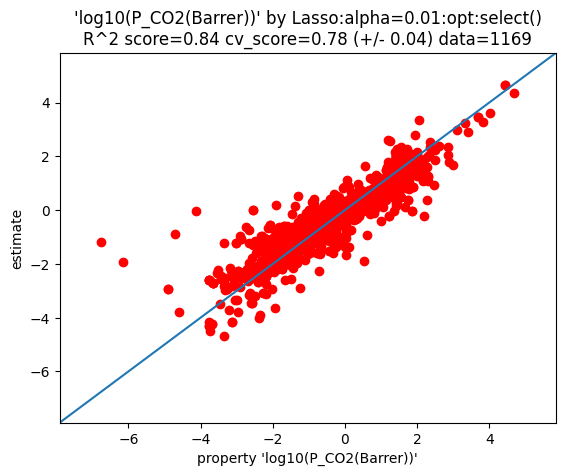

In [8]:
model = df.optimize_and_select_features(
    LassoRegressionModel(df, list(target_property.keys())[0], fp))
model.plot_estimate('molgx_lasso_tg.png')